Select a number of galaxies ($\sim 500$ for testing, $\gtrsim 50,000$ for good results) with intrinsic ellipticities taken from a uniform distribution of ellipticity ($\epsilon$), distortion (e), or axis ratio (q), as given by an option. Also draw the phase uniformly from 0-pi (note that the orientation angle $\phi$ is 0-$\pi$ but in this space you need to cover the whole 0-$2\pi$). Galaxy size is constant, gaussian profile.

For each galaxy:
    Apply an array of shears. Ex: g=\[0+0i, 0.04+0i, -0.04+0i, 0+0.04i, 0-0.04i\], but variable.
    Apply Gaussian PSF and Gaussian noise. The same noise realisation for each shear value for a given galaxy, but different for each galaxy. 
    Rotate intrinsic shape by $n_{rot}$ times, where $n_{rot}$ is a variable. This gets treated as a separate galaxy with its own noise realisation.
    
Now we average: $\hat g = \langle \epsilon \rangle |_g$, converting from distortion to shear as appropriate. Only average galaxies with the same applied shear.
Then we plot $\hat g_1$ vs $g_1$, the observed shear vs real shear, and similarly for $g_2$. Remember to plot errors. Ideally there should be a straight line relation $(1+m_1)g_1 + c_1$ and similar. Fit with scipy curvefit to get parameters. Finally, repeat for different SNR, and plot SNR vs $m$. 

TODOs
Let galsim choose postage stamp size -- DONE 02 July 2018
Stop averaging over g1, g2
Biasing by restricting shape measurement ellipticities to less than one.
    Convert to chi type manually (distortion to q, q to ellipticity) w/ last equation before sec 2.2 of Mandelbaum great3

1) get error on m. Use bootstrap: nlog^2(n)
2) do weighted average over all SNR to find $\hat g$, then find error on m like 1)
Fix a noise level $\sigma_N$, use flux values such that SNR is between 5 and 200. Arun will send me magnitude distribution

Make catalog including
  Galaxy ID, Flux/magnitude, size, sersic n, intrinsic ellipticity
Read table, generate galaxy images. Output catalog:
  Above plus measured ellipticity, measured size

For FFT Size error, see GSParams (search on galsim wiki) and increase minimum_fft_size, pass when you make Sersic profile

In [2]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
from scipy.optimize import curve_fit
import time
import cProfile
import cPickle

In [3]:
#Constants
shape_distribution = ['ellipticity','distortion','axis_ratio']

In [4]:
#Simulation options
distribution_key = 0 #choose shape_distribution from above
nrot = 2 #Number of images per galaxy ie 1 is no rotations, 2 is a 0 and 90 degree rot, etc
ngal = 50#00#00 #Number of galaxies to simulate
shearList = [(0,0),(0.04,0),(-0.04,0),(0,0.04),(0,-0.04)] #list of shears to apply

#Parameters of the galaxy population
gal_flux = 1.e6     #ADU -- Total galaxy flux
disk_n = 0.5  #n for Sersic profile; 1/2 for Gaussian
disk_re = 0.8 #half-light radius, as

#Parameters of the PSF
psf_sigma = 0.5 #as
pixel_scale = 0.3 #as/px

#Parameters of the noise
snrArr = np.linspace(10,100,2) #array of desired SNRs for the Gaussian noise
#snrArr = np.array([100])
#Initialize the galaxy
masterGal = galsim.Sersic(disk_n,half_light_radius=disk_re)
masterGal=masterGal.withFlux(gal_flux)

#Gaussian PSF
psf = galsim.Gaussian(flux=1.,sigma=psf_sigma)
image_psf=psf.drawImage(scale=pixel_scale)



In [5]:
#Generate random numbers for intrinsic galaxy shapes
shape_params = np.random.random((ngal,2))
shape_parameter_type = shape_distribution[distribution_key]

In [6]:
#Generate galaxies
if shape_parameter_type == 'ellipticity':
    galaxies = [masterGal.shear(g=mag, beta=ph*np.pi*galsim.radians) for mag,ph in shape_params]
elif shape_parameter_type == 'distortion':
    galaxies = [masterGal.shear(e=mag, beta=ph*np.pi*galsim.radians) for mag,ph in shape_params]
elif shape_parameter_type == 'axis_ratio':
    galaxies = [masterGal.shear(q=mag, beta=ph*np.pi*galsim.radians) for mag,ph in shape_params]
else:
    raise ValueError, 'shape_parameter_type "%s" not recognized. Use one of the allowed keywords.' %shape_parameter_type
    
#Generate rotated galaxies, add to galaxy list
rotation_angle = [180./(nrot)*i for i in range(1,nrot)]
rot_gals = [gal.rotate(angle*galsim.degrees) for angle in rotation_angle for gal in galaxies]
galaxies += rot_gals

In [7]:
shearedGals = np.array([[gal.shear(g1=shear[0],g2=shear[1]) for gal in galaxies] for shear in shearList])
#shearedGals (numShears, numGals)

In [8]:
#Measure shapes
def measureShape(noise_im, image_psf):
        results = galsim.hsm.EstimateShear(noise_im,image_psf,strict=False, guess_sig_gal=disk_re/pixel_scale, guess_sig_PSF=8.0, shear_est='REGAUSS')
        e1obs,e2obs = results.observed_shape.e1,results.observed_shape.e2
        e1corr,e2corr = results.corrected_e1,results.corrected_e2
        #Biasing by restricting to less than one. Convert to chi type manually (distortion to q, q to ellipticity)
        if results.correction_status==0 and np.sqrt(e1obs**2+e2obs**2)<=1 and np.sqrt(e1corr**2+e2corr**2)<=1:
            obsShear = galsim.Shear(e1=e1obs, e2=e2obs)
            corrShear = galsim.Shear(e1=e1corr, e2=e2corr)
            return [obsShear.g1, obsShear.g2, corrShear.g1, corrShear.g2]
            #return [results.observed_shape.e1,results.observed_shape.e2,\
            #     results.corrected_e1,results.corrected_e2]
        #if shape estimation unsuccessful
        else:
            return [np.nan,np.nan,np.nan,np.nan]
    
def addGaussianNoiseSNR(im,clean_im,snr):
    noise = galsim.GaussianNoise(sigma=1)
    im.addNoiseSNR(noise, snr, preserve_flux=True)
    noise_im = im - clean_im
    return noise_im

In [14]:
startC,startT = time.clock(), time.time()
save_ims = True
obs = []
shearedGalT = shearedGals.transpose()
lost_flux = []
#Iterate over rows of the same galaxy w/ different shears
noisyGals=[]
for galRow in shearedGalT:
    gal_ims = []
    for i,gal in enumerate(galRow):
        #Convolve w/ PSF and draw image
        final = galsim.Convolve([gal, psf])
        if i==0:
            image = final.drawImage(scale=pixel_scale)
        else:
            image_shape = gal_ims[0].array.shape
            im_final = galsim.ImageF(*image_shape)
            image = final.drawImage(image=im_final, scale=pixel_scale)
        if np.abs(np.sum(image.array)/gal_flux - 1) > 1e-2 and i<ngal:
            lost_flux.append((np.sum(image.array)/gal_flux, i, shape_params[i]))
        gal_ims.append(image)

    obs_snr = []
    #Loop through SNRs
    for snr in snrArr:
        #Add noise
        first = gal_ims[0].copy()
        noise_im = addGaussianNoiseSNR(first, gal_ims[0], snr)
        noisyImRow = [im + noise_im for im in gal_ims]
        if save_ims:
            noisyGals.append(noisyImRow)
        #Measure shape
        obsRow = [measureShape(noisyIm, image_psf) for noisyIm in noisyImRow]
        obs_snr.append(obsRow)

    obs.append(obs_snr)

obs = np.array(obs)
obs = obs.transpose(1,0,2,3) #Get desired shape

#Save file
outfile2 = open('../shear_bias_outputs/obs.pkl','wb')
cPickle.dump(obs,outfile2)
outfile2.close()

print 'lost > 1%% flux: %s / %s' % (str(len(lost_flux)),str(ngal))
print 'clock time: %10.1f \n cpu time: %10.1f' % (time.clock()-startC,time.time()-startT)
print 'len(shearedGals) = ', shearedGals.size

#cProfile.run('a()',sort=1)

#obs shape:
#(#SNRs, ngal*nrot, #shears, 4)
#Axis 0: SNR
#Axis 1: Galaxy #
#Axis 2: Shear
#Axis 3 shape measurement: [g1obs, g2obs, g1corr, g2corr] or [nan, nan, nan, nan] in case of failure

lost > 1% flux: 0 / 50
clock time:        3.1 
 cpu time:        3.1
len(shearedGals) =  500


In [10]:
#Make dictionaries to map g1 and g2 to the indeces in shearList and obs
g1Dict = {}
g2Dict = {}
for i,shear in enumerate(shearList):
    g1,g2 = shear
    g1keys = g1Dict.keys()
    if g1 in g1keys:
        g1Dict[g1].append(i)
    else:
        g1Dict[g1] = [i]
    g2keys = g2Dict.keys()
    if g2 in g2keys:
        g2Dict[g2].append(i)
    else:
        g2Dict[g2] = [i]


In [11]:
#Calculate mean / std for each value of g1, g2

#Put different shears in front of array so we can iterate over them easier
shearfrontObs = obs.transpose((2,0,1,3))
g1shear,g2shear=g1Dict.keys(),g2Dict.keys()
shearRes = []
for dct,keys in [(g1Dict,g1shear),(g2Dict,g2shear)]:
    subRes = []
    for key in keys:
        indeces = dct[key]
        subArr = [shearfrontObs[i] for i in indeces]
        #Combine subArrays with same g1 (g2) into a single array
        subArr = np.concatenate(subArr,axis=1)
        #Calculate mean and std of that subArray
        num = np.sum(np.logical_not(np.isnan(subArr)),axis=1) #Number of non-nan entries
        subMean = np.nanmean(subArr, axis=1)
        subErr = np.nanstd(subArr,axis=1) / np.sqrt(num)
        subRes.append([subMean,subErr])
    shearRes.append(subRes)

#Initial Shape:
#(2 (g1,g2), #intrinsic shear values, 2 (mean,err), #SNRs, 4 (shape measurement (g1obs, g2obs, g1corr, g2corr) )
g1Res,g2Res = np.array(shearRes[0]).transpose(2,3,0,1), np.array(shearRes[1]).transpose(2,3,0,1)
g1Res = g1Res[:,0::2,:,:] #Remove e2 measurements from g1
g2Res = g2Res[:,1::2,:,:] #Remove e1 measurements from g2
#Shape: (#SNRs, 2 (shape measurement (gobs, gcorr)), #intrinsic shear values, 2 (mean, err))

In [12]:
def lin(x,m,b):
    return m*x+b

def fitline(shear,res):
    fitparam, fiterr = curve_fit(lin,shear,res[:,0],p0=[1,0],sigma=res[:,1])
    return fitparam

def getFitParameters(shear,Res,corr):
    '''corr=0,1 gives observed (0) or corrected (1) estimates'''
    fitParamArr = []
    for subRes in Res:
        subRes = subRes[corr]
        fitparams = fitline(shear,subRes)
        fitParamArr.append(fitparams)
    return np.stack(fitParamArr) #Shape (#SNRs, 2 (slope, intercept of line))

def plotFit(shear,Res,snr_index,corr,fitparams):
    res = Res[snr_index,corr]
    plt.errorbar(shear, res[:,0],yerr=res[:,1],fmt='.',capsize=4)
    xx=np.linspace(min(shear),max(shear),len(shear)*100)
    plt.plot(xx,lin(xx,*fitparams[snr_index]),'k')
    
i = 1 #corrected; set to 0 for observed
fp=getFitParameters(g1shear,g1Res,i)

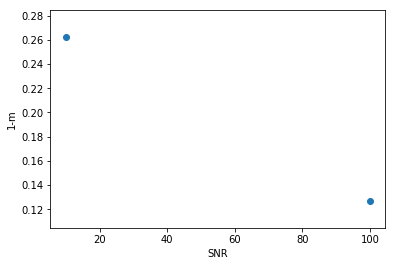

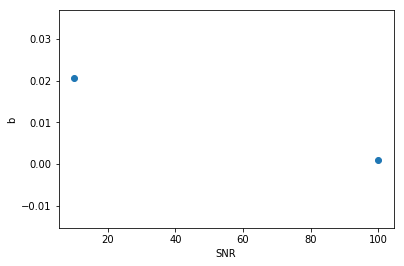

In [13]:
plt.scatter(snrArr, 1-fp[:,0])
plt.xlabel('SNR')
plt.ylabel('1-m')
plt.show()

plt.scatter(snrArr, fp[:,1])
plt.xlabel('SNR')
plt.ylabel('b')
plt.show()

In [20]:
plotFit(g1shear,g1Res,0,1,fp)

ValueError: operands could not be broadcast together with shapes (20,2,3,2) (3,) 

In [ ]:
#for error on m use bootstrap: nlog^2(n)

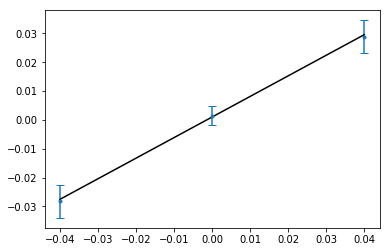

In [19]:
#y axis: measured shear - true shear. x-axis true shear
#Say for which SNR is this plot
#specify SNR through function
plotFit(g1shear,g1Res,0,1,fp)

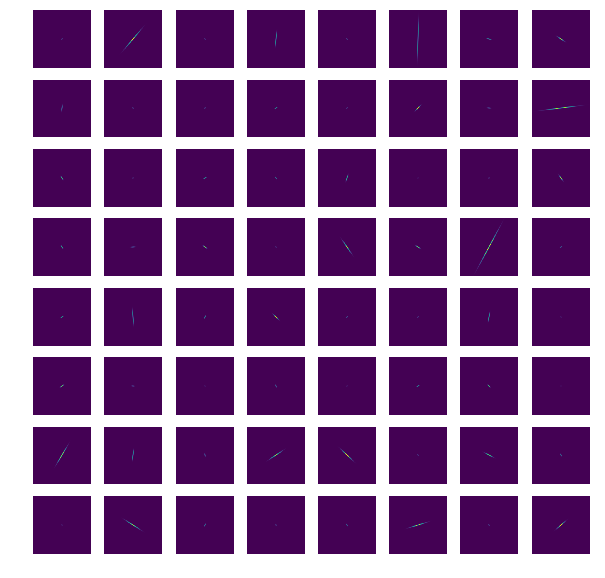

In [72]:
#Plot a bunch of galaxies
fig,ax=plt.subplots(8,8,figsize=(10,10))
for i,gal in enumerate(shearedGals.flatten()[:64]):
    subax=ax[i/8,i%8]
    subax.axes.axis('off')
    im=gal.drawImage()
    arr = im.array
    subax.imshow(arr,interpolation="none")
#     except:
#         print 'plotting failed for image %d' % i


In [65]:
# err = np.nanstd(obs,axis=1) / np.sqrt(np.sum(successMask,axis=1))
# res = np.nanmean(obs,axis=1)
#Shapes (#SNRs, #shears, #measured_values (4))

In [ ]:
# rot_gals=np.array(rot_gals)
# rot_gals=rot_gals.reshape(rot_gals.size/len(galaxies),len(galaxies))
# combo=np.array(galaxies)
# for row in rot_gals:
#     combo = combo + row


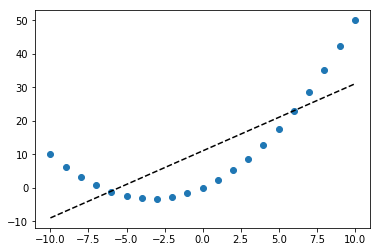

In [33]:
xx = np.linspace(-10,10,21)
noise = np.random.randn(len(xx))
yy = 2*xx + 3 * 0.1*xx*xx
plt.plot(xx,yy,'o')
bestfit, errs = curve_fit(lin,xx,yy)
plt.plot(xx,bestfit[0]*xx+bestfit[1],'k--')